# importing libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GRU
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.layers import Bidirectional
import os
from tensorflow.keras.layers import LSTM
import numpy as np
from __future__ import absolute_import, division, print_function, unicode_literals
import collections
from tensorflow.keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pprint import pprint
from tensorflow.keras.layers import MultiHeadAttention
from __future__ import absolute_import, division, print_function, unicode_literals
from keras.layers import Layer
import keras.backend as K
from tensorflow.keras.layers import GlobalAveragePooling2D, Rescaling
from keras.applications.vgg16 import VGG16


# loading data set

In [ ]:
df = pd.read_csv('train_xy.csv') # reading  training data
test = pd.read_csv('test_x.csv') # reading test data

In [ ]:
# preprocess image data with gray scale

def load_image(file):
    try:
        image = Image.open(
            file
        ).convert('LA').resize((64, 64,2)) # read  image as a greyscale
        arr = np.array(image) # convert  image to an array
    except:
        arr = np.zeros((64, 64, 2)) #  an array of zeros
    return arr


# loading images
x_image = np.array([load_image(i) for i in tqdm(df.image)]) # load each image

# loading summary
x_text = df.summary.astype('str')

  0%|          | 0/7627 [00:00<?, ?it/s]

In [ ]:
# preprocess image data with rgb

def load_image2(file):
    try:
        image = Image.open(
            file
        ).convert('RGB').resize((64, 64, 3)) # read  image as a greyscale
        arr = np.array(image) # convert  image to an array
    except:
        arr = np.zeros((64, 64, 3)) #  an array of zeros
    return arr


# loading images
x_image2 = np.array([load_image2(i) for i in tqdm(df.image)]) # load each image

# loading summary
x_text = df.summary.astype('str')

  0%|          | 0/7627 [00:00<?, ?it/s]

In [ ]:
# labels
y_price =df.price
y_type = df.type.astype('category').cat.codes

len_price = len(y_price.unique()) # number of unique labels for price
len_type = len(y_type.unique()) # number of unique labels for rental type

# splitting the data for gray scale images
x_tr_image, x_vl_image, x_tr_text, x_vl_text, y_tr_price, y_vl_price, y_tr_type, y_vl_type = train_test_split(x_image, x_text,y_price,y_type,test_size=0.2)
#validation splits are containing 20% of the training set

In [ ]:
#spliting the data for rgb images
x_tr_image2, x_vl_image2, x_tr_text, x_vl_text, y_tr_price, y_vl_price, y_tr_type, y_vl_type = train_test_split(x_image2, x_text,y_price,y_type,test_size=0.2)
#validation splits are containing 20% of the training set

In [ ]:
# preprocess text data
vocab_size = 40000 # a threshold
max_len = 100 # maximum sequence length


# build vocabulary from training set
tokenizer = Tokenizer(num_words=vocab_size) # build a tokenizer
tokenizer.fit_on_texts(x_tr_text)


def _preprocess(list_of_text):
    return pad_sequences(
        tokenizer.texts_to_sequences(list_of_text), # transforms
        maxlen=max_len, #  max sequence length of 100
        padding='post', #  add padding at the end to make it 100 words long
    )
x_tr_text_id = _preprocess(x_tr_text) # preprocess on training sequences
x_vl_text_id = _preprocess(x_vl_text) # preprocess on validation sequences

print(x_tr_text_id.shape)
print(x_vl_text_id.shape)

(6101, 100)
(1526, 100)


In [ ]:
x_test_summary = _preprocess(test.summary.astype(str)) # create sequences
x_test_image2 = np.array([load_image2(i) for i in tqdm(test.image)]) #  resize the images from the test set with rgb

  0%|          | 0/7360 [00:00<?, ?it/s]

In [ ]:
x_test_summary = _preprocess(test.summary.astype(str)) # create sequences
x_test_image = np.array([load_image(i) for i in tqdm(test.image)]) #  resize the images from the test set with gray scale

  0%|          | 0/7360 [00:00<?, ?it/s]

In [ ]:
# printing the first 5 text sequences
pprint(tokenizer.sequences_to_texts(x_tr_text_id[:5]))

['notre logement est idéal pour un couple de voyageur désirant visiter '
 "montréal vous aurez accès à la totalité de l'appartement et vous pourrez y "
 'vivre comme bon vous semble nous apprécierons toujours faire votre '
 'connaissance et partagez notre expérience de la ville pour enrichir la votre '
 'our flat is ideal for traveling couples willing to discover montréal you '
 'will have full access to the flat and you are free to come and go we will '
 'appreciate to share our experience with you',
 'located in the golden mile of downtown montreal a quiet neighbourhood that’s '
 'close to the action on saint catherine and saint denis',
 'the gab maison is the first shared living space in montreal for the '
 'wandering souls of the sedentary era it is a unique communal home in the '
 'heart of the city is a calm and cozy space which keeps with montreal’s '
 'artistic and cosmopolitan vibe it is perfect place for those just passing '
 'through or looking to settle in montreal for stay

In [ ]:
# number of unique words contained in the vocabulary
print('total words in the dictionary:', tokenizer.num_words)

total words in the dictionary: 40000


In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=10, )]
# setting patience 10

# first trail simple network with rgb images

In [ ]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 3))

# text
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # word embeddings
averaged = tf.reduce_mean(embedded, axis=1) # compute the mean

# image
cov = Conv2D(32, (16, 16))(in_image) # convolutional layer with 32 filters, and a 16x16 mask
pl = MaxPool2D((16, 16))(cov) # max pooling with a 16x16 mask
flattened = Flatten()(pl) # flatten the shape

# fusion
fused = tf.concat([averaged, flattened], axis=-1) # combine text features with images

# multi-objectives
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label
p_type = Dense(len_type, activation='softmax', name='type')(fused)

# build model
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'price': p_price,
        'type': p_type,
    },
)
# compile model
model.compile(
    optimizer=Adam(), # using Adam for optimization
    # using sparse categorical cross-entropy loss since our labels are integers
    loss={
        'price': 'sparse_categorical_crossentropy',
        'type': 'sparse_categorical_crossentropy',
    },
    # equally weight
    loss_weights={
        'price': 0.5,
        'type': 0.5,
    },
    # evaluation metric is accuracy
    metrics={
        'price': ['SparseCategoricalAccuracy'],
        'type': ['SparseCategoricalAccuracy'],
    },
)


model.summary() # print the model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 49, 49, 32)   24608       ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     4000000     ['input_1[0][0]']                
                                                                                              

In [ ]:
# fit our model
history = model.fit(
    #  inputs text sequences and  image
    x={
        'summary': x_tr_text_id,
        'image': x_tr_image2
    },
    #  outputs price and rental
    y={
        'price': y_tr_price,
        'type': y_tr_type,
    },
    epochs=20, # train for 20 epochs
    batch_size=8,
    validation_data=(
        {
            'summary': x_vl_text_id,
            'image': x_vl_image2
         },
        {
            'price': y_vl_price,
            'type': y_vl_type,
        }),
    validation_split=0.2, # validate on a hold-out set of 20%
    # use early stopping
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, )
    ],
    verbose=1
)

Epoch 1/20
610/610 [==============================] - 49s 73ms/step - loss: 0.9904 - price_loss: 0.8327 - type_loss: 1.1481 - price_sparse_categorical_accuracy: 0.6230 - type_sparse_categorical_accuracy: 0.7512 - val_loss: 0.8959 - val_price_loss: 0.8096 - val_type_loss: 0.9823 - val_price_sparse_categorical_accuracy: 0.6151 - val_type_sparse_categorical_accuracy: 0.7674
Epoch 2/20
610/610 [==============================] - 52s 85ms/step - loss: 0.8691 - price_loss: 0.7732 - type_loss: 0.9650 - price_sparse_categorical_accuracy: 0.6480 - type_sparse_categorical_accuracy: 0.7545 - val_loss: 0.8530 - val_price_loss: 0.7723 - val_type_loss: 0.9337 - val_price_sparse_categorical_accuracy: 0.6388 - val_type_sparse_categorical_accuracy: 0.7674
Epoch 3/20
610/610 [==============================] - 51s 84ms/step - loss: 0.8036 - price_loss: 0.7044 - type_loss: 0.9028 - price_sparse_categorical_accuracy: 0.6873 - type_sparse_categorical_accuracy: 0.7559 - val_loss: 0.8157 - val_price_loss: 0.73

In [ ]:
#  predictions on the test set
y_predict = model.predict(
    {
        'summary': x_test_summary,
        'image': x_test_image2
    }
)

price_predicted = y_predict['price']
print(price_predicted)
price_category_predicted = np.argmax(price_predicted, axis=1)
print(price_category_predicted)

#  submission csv
pd.DataFrame(
    {'id': test.id,
     'price': price_category_predicted}).to_csv('sample_submission.csv', index=False)

[[0.759334   0.19407992 0.04658607]
 [0.9780568  0.01706753 0.00487572]
 [0.88446224 0.06217538 0.05336236]
 ...
 [0.7248444  0.2446812  0.03047441]
 [0.9875693  0.00874319 0.00368762]
 [0.7951708  0.17401569 0.03081357]]
[0 0 0 ... 0 0 0]


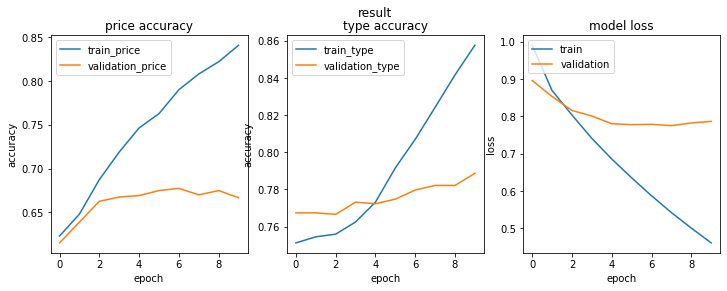

In [ ]:
#  accuracy and loss curves

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
fig.suptitle('result')
#  training price accuracy and the validation price accuracy
ax1.plot(history.history['price_sparse_categorical_accuracy'])
ax1.plot(history.history['val_price_sparse_categorical_accuracy'])
ax1.set_title('price accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train_price', 'validation_price'], loc='upper left')
#  specified accuracy metric and type accuracy
ax2.plot(history.history['type_sparse_categorical_accuracy'])
ax2.plot(history.history['val_type_sparse_categorical_accuracy'])
ax2.set_title('type accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train_type', 'validation_type'], loc='upper left')
# the training loss and the validation loss
ax3.plot(history.history['loss'])
ax3.plot(history.history['val_loss'])
ax3.set_title('model loss')
ax3.set_ylabel('loss')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'validation'], loc='upper left')
plt.show() # display the figure

this gave me the best accuracy with rgb images

# second trail  simple network with gray scale images

In [ ]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # word embeddings
averaged = tf.reduce_mean(embedded, axis=1) # compute the mean

# image
cov = Conv2D(32, (16, 16))(in_image) # convolutional layer with 32 filters, and a 16x16 mask
pl = MaxPool2D((16, 16))(cov) # max pooling with a 16x16 mask
flattened = Flatten()(pl) # flatten the shape

# fusion
fused = tf.concat([averaged, flattened], axis=-1) # combine text features with images

# multi-objectives
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label
p_type = Dense(len_type, activation='softmax', name='type')(fused)

# build model
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'price': p_price,
        'type': p_type,
    },
)
# compile model
model.compile(
    optimizer=Adam(), # using Adam for optimization
    # using sparse categorical cross-entropy loss since our labels are integers
    loss={
        'price': 'sparse_categorical_crossentropy',
        'type': 'sparse_categorical_crossentropy',
    },
    # equally weight
    loss_weights={
        'price': 0.5,
        'type': 0.5,
    },
    # evaluation metric is accuracy
    metrics={
        'price': ['SparseCategoricalAccuracy'],
        'type': ['SparseCategoricalAccuracy'],
    },
)


model.summary() # print the model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 49, 49, 32)   24608       ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     4000000     ['input_1[0][0]']                
                                                                                              

In [ ]:
# fit our model
history = model.fit(
    #  inputs text sequences and  image
    x={
        'summary': x_tr_text_id,
        'image': x_tr_image
    },
    #  outputs price and rental
    y={
        'price': y_tr_price,
        'type': y_tr_type,
    },
    epochs=20, # train for 20 epochs
    batch_size=8,
    validation_data=(
        {
            'summary': x_vl_text_id,
            'image': x_vl_image
         },
        {
            'price': y_vl_price,
            'type': y_vl_type,
        }),
    validation_split=0.2, # validate on a hold-out set of 20%
    # use early stopping
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, )
    ],
    verbose=1
)

Epoch 1/20
610/610 [==============================] - 49s 73ms/step - loss: 0.9904 - price_loss: 0.8327 - type_loss: 1.1481 - price_sparse_categorical_accuracy: 0.6230 - type_sparse_categorical_accuracy: 0.7512 - val_loss: 0.8959 - val_price_loss: 0.8096 - val_type_loss: 0.9823 - val_price_sparse_categorical_accuracy: 0.6151 - val_type_sparse_categorical_accuracy: 0.7674
Epoch 2/20
610/610 [==============================] - 52s 85ms/step - loss: 0.8691 - price_loss: 0.7732 - type_loss: 0.9650 - price_sparse_categorical_accuracy: 0.6480 - type_sparse_categorical_accuracy: 0.7545 - val_loss: 0.8530 - val_price_loss: 0.7723 - val_type_loss: 0.9337 - val_price_sparse_categorical_accuracy: 0.6388 - val_type_sparse_categorical_accuracy: 0.7674
Epoch 3/20
610/610 [==============================] - 51s 84ms/step - loss: 0.8036 - price_loss: 0.7044 - type_loss: 0.9028 - price_sparse_categorical_accuracy: 0.6873 - type_sparse_categorical_accuracy: 0.7559 - val_loss: 0.8157 - val_price_loss: 0.73

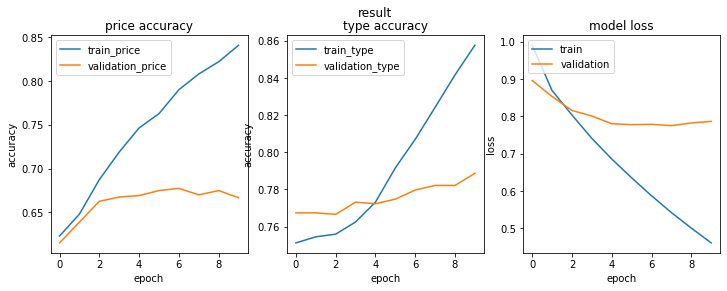

In [ ]:
#  accuracy and loss curves

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
fig.suptitle('result')
#  training price accuracy and the validation price accuracy
ax1.plot(history.history['price_sparse_categorical_accuracy'])
ax1.plot(history.history['val_price_sparse_categorical_accuracy'])
ax1.set_title('price accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train_price', 'validation_price'], loc='upper left')
#  specified accuracy metric and type accuracy
ax2.plot(history.history['type_sparse_categorical_accuracy'])
ax2.plot(history.history['val_type_sparse_categorical_accuracy'])
ax2.set_title('type accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train_type', 'validation_type'], loc='upper left')
# the training loss and the validation loss
ax3.plot(history.history['loss'])
ax3.plot(history.history['val_loss'])
ax3.set_title('model loss')
ax3.set_ylabel('loss')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'validation'], loc='upper left')
plt.show() # display the figure

In [ ]:
#  predictions on the test set
y_predict = model.predict(
    {
        'summary': x_test_summary,
        'image': x_test_image
    }
)

price_predicted = y_predict['price']
print(price_predicted)
price_category_predicted = np.argmax(price_predicted, axis=1)
print(price_category_predicted)

#  submission csv
pd.DataFrame(
    {'id': test.id,
     'price': price_category_predicted}).to_csv('sample_submission.csv', index=False)

[[0.759334   0.19407992 0.04658607]
 [0.9780568  0.01706753 0.00487572]
 [0.88446224 0.06217538 0.05336236]
 ...
 [0.7248444  0.2446812  0.03047441]
 [0.9875693  0.00874319 0.00368762]
 [0.7951708  0.17401569 0.03081357]]
[0 0 0 ... 0 0 0]


The accuracy and loss on training and validation splits are noisy

put  an LSTM layer and vary the number of units. i think it will make an improvement

# third trail with LSTM

In [ ]:
#same as trail 1
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get  word embeddings


lstm = LSTM(50)(embedded)

# image part
cov = Conv2D(32, (16, 16))(in_image)
pl = MaxPool2D((16, 16))(cov)
flattened = Flatten()(pl)


# fusion
fused = tf.concat([lstm, flattened], axis=-1)

# multi-objectives
p_price = Dense(len_price, activation='softmax', name='price')(fused)
p_type = Dense(len_type, activation='softmax', name='type')(fused)

#build model
lstm_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price,
        'type': p_type,
    },
)
# compile model
lstm_model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss={
          'price': 'sparse_categorical_crossentropy',
          'type': 'sparse_categorical_crossentropy',
      },

      loss_weights={
          'price': 0.5,
          'type': 0.5,
      },

      metrics={
          'price': ['SparseCategoricalAccuracy'],
          'type': ['SparseCategoricalAccuracy'],
      },
  )
lstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 49, 49, 32)   16416       ['input_4[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 100)     4000000     ['input_3[0][0]']                
                                                                                            

In [ ]:
# same as the first one still have not chanaged anything
history =lstm_model.fit(
      x={
          'summary': x_tr_text_id,
          'image': x_tr_image
      },
      y={
          'price': y_tr_price,
          'type': y_tr_type,
      },
     epochs=20,
     batch_size=16,
     validation_data=(
          {
              'summary': x_vl_text_id,
              'image': x_vl_image
          },
          {
              'price': y_vl_price,
              'type': y_vl_type,
          }),
      validation_split=0.2,
      callbacks=callbacks,
      verbose=1
  )

Epoch 1/20
305/305 [==============================] - 32s 99ms/step - loss: 1.0089 - price_loss: 0.8521 - type_loss: 1.1656 - price_sparse_categorical_accuracy: 0.6262 - type_sparse_categorical_accuracy: 0.7492 - val_loss: 0.9170 - val_price_loss: 0.8389 - val_type_loss: 0.9952 - val_price_sparse_categorical_accuracy: 0.6069 - val_type_sparse_categorical_accuracy: 0.7674
Epoch 2/20
305/305 [==============================] - 31s 101ms/step - loss: 0.9251 - price_loss: 0.8362 - type_loss: 1.0140 - price_sparse_categorical_accuracy: 0.6262 - type_sparse_categorical_accuracy: 0.7545 - val_loss: 0.9182 - val_price_loss: 0.8363 - val_type_loss: 1.0002 - val_price_sparse_categorical_accuracy: 0.6069 - val_type_sparse_categorical_accuracy: 0.7674
Epoch 3/20
305/305 [==============================] - 30s 100ms/step - loss: 0.9243 - price_loss: 0.8356 - type_loss: 1.0129 - price_sparse_categorical_accuracy: 0.6262 - type_sparse_categorical_accuracy: 0.7545 - val_loss: 0.9159 - val_price_loss: 0.

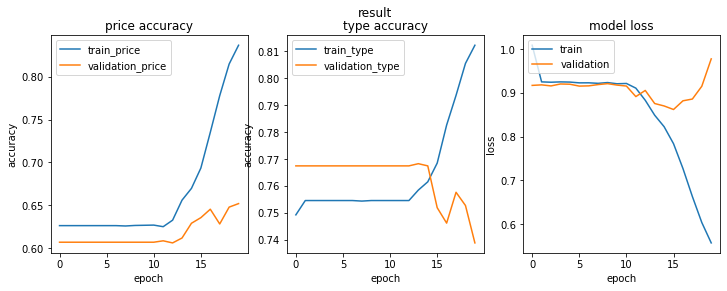

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
fig.suptitle('result')
#  training price accuracy and the validation price accuracy
ax1.plot(history.history['price_sparse_categorical_accuracy'])
ax1.plot(history.history['val_price_sparse_categorical_accuracy'])
ax1.set_title('price accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train_price', 'validation_price'], loc='upper left')
#  specified accuracy metric and type accuracy
ax2.plot(history.history['type_sparse_categorical_accuracy'])
ax2.plot(history.history['val_type_sparse_categorical_accuracy'])
ax2.set_title('type accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train_type', 'validation_type'], loc='upper left')
# the training loss and the validation loss
ax3.plot(history.history['loss'])
ax3.plot(history.history['val_loss'])
ax3.set_title('model loss')
ax3.set_ylabel('loss')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'validation'], loc='upper left')
plt.show() # display the figure

In [ ]:
# predictions
y_predict =lstm_model.predict(
      {
          'summary': x_test_summary,
          'image': x_test_image
      }
  )
price_predicted = y_predict['price']
price_category_predicted = np.argmax(price_predicted, axis=1)

  #  submission csv
pd.DataFrame(
      {'id': test.id,
      'price': price_category_predicted}).to_csv('LSTM.csv', index=False)

The LSTM layer improved the test accuracy on the leaderboard but it was not good with bgr images

  try GRU layer instead  hope that the performance will improves

# forth trail with GRU

In [ ]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)
lstm = GRU(20)(embedded)

# image part
cov = Conv2D(32, (16, 16))(in_image)
pl = MaxPool2D((16, 16))(cov)
flattened = Flatten()(pl)


# fusion
fused = tf.concat([lstm, flattened], axis=-1)

# multi-objectives
p_price = Dense(len_price, activation='softmax', name='price')(fused)
p_type = Dense(len_type, activation='softmax', name='type')(fused)

# model
gru_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price,
        'type': p_type,
    },
)

gru_model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss={
          'price': 'sparse_categorical_crossentropy',
          'type': 'sparse_categorical_crossentropy',
      },

      loss_weights={
          'price': 0.5,
          'type': 0.5,
      },

      metrics={
          'price': ['SparseCategoricalAccuracy'],
          'type': ['SparseCategoricalAccuracy'],
      },
  )
gru_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 49, 49, 32)   16416       ['input_6[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 100)     4000000     ['input_5[0][0]']                
                                                                                            

In [ ]:
history =gru_model.fit(
      x={
          'summary': x_tr_text_id,
          'image': x_tr_image
      },
      y={
          'price': y_tr_price,
          'type': y_tr_type,
      },
     epochs=20,
     batch_size=16,
     validation_data=(
          {
              'summary': x_vl_text_id,
              'image': x_vl_image
          },
          {
              'price': y_vl_price,
              'type': y_vl_type,
          }),
      validation_split=0.2,
      callbacks=callbacks,
      verbose=1
  )

Epoch 1/20
305/305 [==============================] - 31s 97ms/step - loss: 1.0516 - price_loss: 0.8567 - type_loss: 1.2465 - price_sparse_categorical_accuracy: 0.6262 - type_sparse_categorical_accuracy: 0.7502 - val_loss: 0.9170 - val_price_loss: 0.8387 - val_type_loss: 0.9954 - val_price_sparse_categorical_accuracy: 0.6069 - val_type_sparse_categorical_accuracy: 0.7674
Epoch 2/20
305/305 [==============================] - 30s 100ms/step - loss: 0.9230 - price_loss: 0.8342 - type_loss: 1.0117 - price_sparse_categorical_accuracy: 0.6262 - type_sparse_categorical_accuracy: 0.7545 - val_loss: 0.9238 - val_price_loss: 0.8421 - val_type_loss: 1.0056 - val_price_sparse_categorical_accuracy: 0.6069 - val_type_sparse_categorical_accuracy: 0.7674
Epoch 3/20
305/305 [==============================] - 30s 100ms/step - loss: 0.9193 - price_loss: 0.8303 - type_loss: 1.0082 - price_sparse_categorical_accuracy: 0.6262 - type_sparse_categorical_accuracy: 0.7545 - val_loss: 0.9056 - val_price_loss: 0.

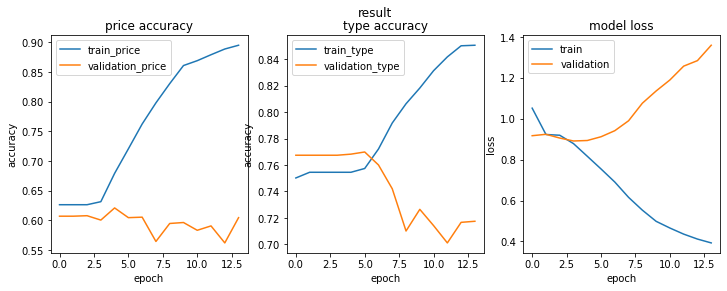

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
fig.suptitle('result')
#  training price accuracy and the validation price accuracy
ax1.plot(history.history['price_sparse_categorical_accuracy'])
ax1.plot(history.history['val_price_sparse_categorical_accuracy'])
ax1.set_title('price accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train_price', 'validation_price'], loc='upper left')
#  specified accuracy metric and type accuracy
ax2.plot(history.history['type_sparse_categorical_accuracy'])
ax2.plot(history.history['val_type_sparse_categorical_accuracy'])
ax2.set_title('type accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train_type', 'validation_type'], loc='upper left')
# the training loss and the validation loss
ax3.plot(history.history['loss'])
ax3.plot(history.history['val_loss'])
ax3.set_title('model loss')
ax3.set_ylabel('loss')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'validation'], loc='upper left')
plt.show() # display the figure

In [ ]:
y_predict = gru_model.predict(
      {
          'summary': x_test_summary,
          'image': x_test_image
      }
  )
price_predicted = y_predict['price']
price_category_predicted = np.argmax(price_predicted, axis=1)
pd.DataFrame(
      {'id': test.id,
      'price': price_category_predicted}).to_csv('GRU.csv', index=False)

The GRU model  improved the performance on the leaderboard. aslo not good with rgb images

try to  add depth to the CNN for the image part

#  trail  5 with drop out

In [ ]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))
# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)
lstm = GRU(20)(embedded)

# image part
cov = Conv2D(32, (3, 3))(in_image)
pl = MaxPool2D((3, 3))(cov)
cov2 = Conv2D(32, (2,2))(pl)
pl2 = MaxPool2D((2,2))(cov2)
flattened = Flatten()(pl2)


# fusion
fused = tf.concat([lstm, flattened], axis=-1)
p_price = Dense(len_price, activation='softmax', name='price')(fused)
p_type = Dense(len_type, activation='softmax', name='type')(fused)

# model
cnn_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price,
        'type': p_type,
    },
)


cnn_model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss={
          'price': 'sparse_categorical_crossentropy',
          'type': 'sparse_categorical_crossentropy',
      },

      loss_weights={
          'price': 0.5,
          'type': 0.5,
      },

      metrics={
          'price': ['SparseCategoricalAccuracy'],
          'type': ['SparseCategoricalAccuracy'],
      },
  )
cnn_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 62, 62, 32)   608         ['input_8[0][0]']                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 20, 20, 32)  0           ['conv2d_3[0][0]']               
                                                                                                  
 input_7 (InputLayer)           [(None, 100)]        0           []                               
                                                                                            

In [ ]:
history =cnn_model.fit(
      x={
          'summary': x_tr_text_id,
          'image': x_tr_image
      },
      y={
          'price': y_tr_price,
          'type': y_tr_type,
      },
     epochs=20,
     batch_size=16,
     validation_data=(
          {
              'summary': x_vl_text_id,
              'image': x_vl_image
          },
          {
              'price': y_vl_price,
              'type': y_vl_type,
          }),
      validation_split=0.2,
      callbacks=callbacks,
      verbose=1
  )

Epoch 1/20
305/305 [==============================] - 24s 74ms/step - loss: 0.9841 - price_loss: 0.8526 - type_loss: 1.1156 - price_sparse_categorical_accuracy: 0.6262 - type_sparse_categorical_accuracy: 0.7494 - val_loss: 0.9334 - val_price_loss: 0.8488 - val_type_loss: 1.0179 - val_price_sparse_categorical_accuracy: 0.6069 - val_type_sparse_categorical_accuracy: 0.7674
Epoch 2/20
305/305 [==============================] - 22s 71ms/step - loss: 0.9290 - price_loss: 0.8364 - type_loss: 1.0217 - price_sparse_categorical_accuracy: 0.6262 - type_sparse_categorical_accuracy: 0.7545 - val_loss: 0.9219 - val_price_loss: 0.8375 - val_type_loss: 1.0063 - val_price_sparse_categorical_accuracy: 0.6069 - val_type_sparse_categorical_accuracy: 0.7674
Epoch 3/20
305/305 [==============================] - 22s 72ms/step - loss: 0.9277 - price_loss: 0.8363 - type_loss: 1.0191 - price_sparse_categorical_accuracy: 0.6262 - type_sparse_categorical_accuracy: 0.7545 - val_loss: 0.9193 - val_price_loss: 0.83

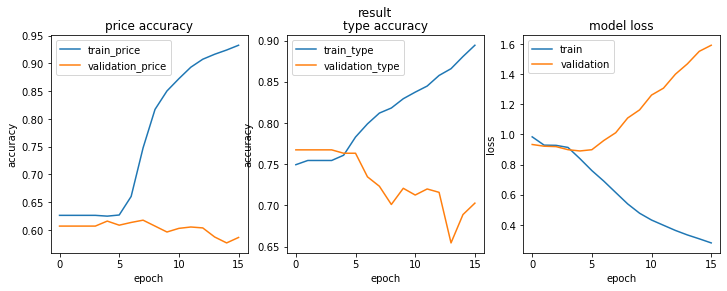

In [ ]:
# from these results, it looks like we're starting to overfit
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
fig.suptitle('result')
#  training price accuracy and the validation price accuracy
ax1.plot(history.history['price_sparse_categorical_accuracy'])
ax1.plot(history.history['val_price_sparse_categorical_accuracy'])
ax1.set_title('price accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train_price', 'validation_price'], loc='upper left')
#  specified accuracy metric and type accuracy
ax2.plot(history.history['type_sparse_categorical_accuracy'])
ax2.plot(history.history['val_type_sparse_categorical_accuracy'])
ax2.set_title('type accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train_type', 'validation_type'], loc='upper left')
# the training loss and the validation loss
ax3.plot(history.history['loss'])
ax3.plot(history.history['val_loss'])
ax3.set_title('model loss')
ax3.set_ylabel('loss')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'validation'], loc='upper left')
plt.show() # display the figure

In [ ]:
y_predict = cnn_model.predict(
      {
          'summary': x_test_summary,
          'image': x_test_image
      }
  )
price_predicted = y_predict['price']
price_category_predicted = np.argmax(price_predicted, axis=1)
pd.DataFrame(
      {'id': test.id,
      'price': price_category_predicted}).to_csv('drop_out.csv', index=False)

slight performance improvement  but this also resulted in overfitting.also not good with bgr images

try to add bidirectionality to the GRU layer.

# trail 6 with bidirectional

In [ ]:


in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)
bi_lstm = Bidirectional(GRU(20))(embedded) # creating a bidirectional GRU layer, with 20 units as before

# image part
cov = Conv2D(32, (3, 3))(in_image) # convolutional layer with 32 filters, and a 16x16 mask, no padding
pl = MaxPool2D((3, 3))(cov) # max pooling with a 3x3 mask, reducing the size to 20x20x32
cov2 = Conv2D(32, (2,2))(pl) # convolutional layer with 32 filters, and a 2x2 mask, no padding
pl2 = MaxPool2D((2,2))(cov2) # max pooling with a 2x2 mask, reducing the size to 9x9x32
flattened = Flatten()(pl2) # flatten the shape to (2592,)


# fusion
fused = tf.concat([bi_lstm, flattened], axis=-1) # concatenate text features with images

# multi-objectives
p_price = Dense(len_price, activation='softmax', name='price')(fused)
p_type = Dense(len_type, activation='softmax', name='type')(fused)

# model
bi_lstm_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price,
        'type': p_type,
    },
)

# compiling the bidirectional model
bi_lstm_model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss={
          'price': 'sparse_categorical_crossentropy',
          'type': 'sparse_categorical_crossentropy',
      },

      loss_weights={
          'price': 0.5,
          'type': 0.5,
      },

      metrics={
          'price': ['SparseCategoricalAccuracy'],
          'type': ['SparseCategoricalAccuracy'],
      },
  )
bi_lstm_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 62, 62, 32)   608         ['input_10[0][0]']               
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 20, 20, 32)  0           ['conv2d_5[0][0]']               
                                                                                                  
 input_9 (InputLayer)           [(None, 100)]        0           []                               
                                                                                            

In [ ]:
history =bi_lstm_model.fit(
      x={
          'summary': x_tr_text_id,
          'image': x_tr_image
      },
      y={
          'price': y_tr_price,
          'type': y_tr_type,
      },
     epochs=20,
     batch_size=16,
     validation_data=(
          {
              'summary': x_vl_text_id,
              'image': x_vl_image
          },
          {
              'price': y_vl_price,
              'type': y_vl_type,
          }),
      validation_split=0.2,
      callbacks=callbacks,
      verbose=1
  )

Epoch 1/20
305/305 [==============================] - 27s 80ms/step - loss: 0.9526 - price_loss: 0.8298 - type_loss: 1.0754 - price_sparse_categorical_accuracy: 0.6277 - type_sparse_categorical_accuracy: 0.7488 - val_loss: 0.8876 - val_price_loss: 0.8222 - val_type_loss: 0.9530 - val_price_sparse_categorical_accuracy: 0.5815 - val_type_sparse_categorical_accuracy: 0.7674
Epoch 2/20
305/305 [==============================] - 23s 77ms/step - loss: 0.8038 - price_loss: 0.7317 - type_loss: 0.8760 - price_sparse_categorical_accuracy: 0.6732 - type_sparse_categorical_accuracy: 0.7627 - val_loss: 0.8432 - val_price_loss: 0.7918 - val_type_loss: 0.8946 - val_price_sparse_categorical_accuracy: 0.6405 - val_type_sparse_categorical_accuracy: 0.7740
Epoch 3/20
305/305 [==============================] - 26s 85ms/step - loss: 0.7211 - price_loss: 0.6650 - type_loss: 0.7772 - price_sparse_categorical_accuracy: 0.7139 - type_sparse_categorical_accuracy: 0.7805 - val_loss: 0.8796 - val_price_loss: 0.85

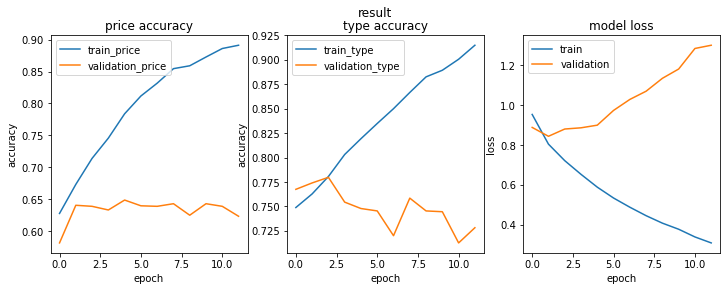

In [ ]:
# Still overfitting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
fig.suptitle('result')
#  training price accuracy and the validation price accuracy
ax1.plot(history.history['price_sparse_categorical_accuracy'])
ax1.plot(history.history['val_price_sparse_categorical_accuracy'])
ax1.set_title('price accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train_price', 'validation_price'], loc='upper left')
#  specified accuracy metric and type accuracy
ax2.plot(history.history['type_sparse_categorical_accuracy'])
ax2.plot(history.history['val_type_sparse_categorical_accuracy'])
ax2.set_title('type accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train_type', 'validation_type'], loc='upper left')
# the training loss and the validation loss
ax3.plot(history.history['loss'])
ax3.plot(history.history['val_loss'])
ax3.set_title('model loss')
ax3.set_ylabel('loss')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'validation'], loc='upper left')
plt.show() # display the figure

In [ ]:

y_predict = bi_lstm_model.predict(
      {
          'summary': x_test_summary,
          'image': x_test_image
      }
  )
price_predicted = y_predict['price']
price_category_predicted = np.argmax(price_predicted, axis=1)
pd.DataFrame(
      {'id': test.id,
      'price': price_category_predicted}).to_csv('bidirectional.csv', index=False)

 still overfitting, and not improved the performance

 Add drop-out regularization in the image  to reduce the overfitting .
 using L2  regularization on the text

# trail 7 with regularization

In [ ]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)
bi_lstm = Bidirectional(GRU(20, recurrent_regularizer='l2'))(embedded) # adding quadratic regularizer

# image part
cov = Conv2D(32, (3, 3))(in_image)
drop = Dropout(0.2)(cov)
pl = MaxPool2D((3, 3))(drop)
cov2 = Conv2D(32, (2,2))(pl)
drop2 = Dropout(0.2)(cov2)
pl2 = MaxPool2D((2,2))(drop2)
flattened = Flatten()(pl2)


# fusion
fused = tf.concat([bi_lstm, flattened], axis=-1)

# multi-objectives
p_price = Dense(len_price, activation='softmax', name='price')(fused)
p_type = Dense(len_type, activation='softmax', name='type')(fused)

# model definition
bi_lstm_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price,
        'type': p_type,
    },
)

bi_lstm_model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss={
          'price': 'sparse_categorical_crossentropy',
          'type': 'sparse_categorical_crossentropy',
      },

      loss_weights={
          'price': 0.5,
          'type': 0.5,
      },

      metrics={
          'price': ['SparseCategoricalAccuracy'],
          'type': ['SparseCategoricalAccuracy'],
      },
  )
bi_lstm_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 62, 62, 32)   608         ['input_12[0][0]']               
                                                                                                  
 dropout (Dropout)              (None, 62, 62, 32)   0           ['conv2d_7[0][0]']               
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 20, 20, 32)  0           ['dropout[0][0]']                
                                                                                            

In [ ]:
# increasing the batch size to 64 to improve training speed, still 20 epochs
history =bi_lstm_model.fit(
      x={
          'summary': x_tr_text_id,
          'image': x_tr_image
      },
      y={
          'price': y_tr_price,
          'type': y_tr_type,
      },
     epochs=20,
     batch_size=64,
     validation_data=(
          {
              'summary': x_vl_text_id,
              'image': x_vl_image
          },
          {
              'price': y_vl_price,
              'type': y_vl_type,
          }),
      validation_split=0.2,
      callbacks=callbacks,
      verbose=1
  )

Epoch 1/20
77/77 [==============================] - 22s 241ms/step - loss: 1.3887 - price_loss: 0.8711 - type_loss: 1.3891 - price_sparse_categorical_accuracy: 0.6238 - type_sparse_categorical_accuracy: 0.7453 - val_loss: 1.1610 - val_price_loss: 0.9149 - val_type_loss: 1.1034 - val_price_sparse_categorical_accuracy: 0.6069 - val_type_sparse_categorical_accuracy: 0.7674
Epoch 2/20
77/77 [==============================] - 17s 217ms/step - loss: 0.9991 - price_loss: 0.8062 - type_loss: 0.9919 - price_sparse_categorical_accuracy: 0.6293 - type_sparse_categorical_accuracy: 0.7545 - val_loss: 0.9742 - val_price_loss: 0.8190 - val_type_loss: 1.0067 - val_price_sparse_categorical_accuracy: 0.6233 - val_type_sparse_categorical_accuracy: 0.7674
Epoch 3/20
77/77 [==============================] - 17s 225ms/step - loss: 0.8726 - price_loss: 0.7377 - type_loss: 0.9180 - price_sparse_categorical_accuracy: 0.6697 - type_sparse_categorical_accuracy: 0.7564 - val_loss: 0.9273 - val_price_loss: 0.7876 

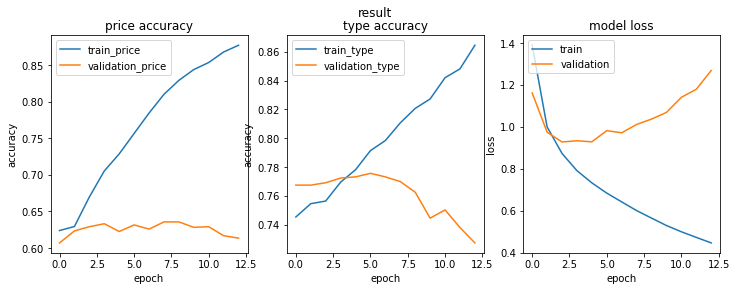

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
fig.suptitle('result')
#  training price accuracy and the validation price accuracy
ax1.plot(history.history['price_sparse_categorical_accuracy'])
ax1.plot(history.history['val_price_sparse_categorical_accuracy'])
ax1.set_title('price accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train_price', 'validation_price'], loc='upper left')
#  specified accuracy metric and type accuracy
ax2.plot(history.history['type_sparse_categorical_accuracy'])
ax2.plot(history.history['val_type_sparse_categorical_accuracy'])
ax2.set_title('type accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train_type', 'validation_type'], loc='upper left')
# the training loss and the validation loss
ax3.plot(history.history['loss'])
ax3.plot(history.history['val_loss'])
ax3.set_title('model loss')
ax3.set_ylabel('loss')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'validation'], loc='upper left')
plt.show() # display the figure

In [ ]:
y_predict = bi_lstm_model.predict(
      {
          'summary': x_test_summary,
          'image': x_test_image
      }
  )
price_predicted = y_predict['price']
price_category_predicted = np.argmax(price_predicted, axis=1)
pd.DataFrame(
      {'id': test.id,
      'price': price_category_predicted}).to_csv('regularization.csv', index=False)

caused the model to underfit but  Loss curve is much smoother

increasing batch size reduced training time but appeared to hurt performance.
varying the number of hidden units in the bidirectional GRU layer did not appear to affect performance


# questions

# Is fully-connected model a good one for sequential data? Why? How about for image data? Is it good? Why?
No, it is not good for both as the number of parameters will increase exponentially which will make the model computationally expensive and it will not be able to keep information from the previous input which is the main idea of sequence models and for images, it will not be able to extract features like convolutional layers and that's why it is only used to combine the upper layer features.

#  What is gradient vanishing and gradient explosion, and how GRU/LSTM tries to mitigate this problem?

🔥A2. Vanishing and exploding gradients are a phenomena in recurrent neural networks where gradients become exponentially larger or smaller the further they are backpropagated through network layers. This is due to the chain rule which results in the repeated multiplication of gradients when computing the gradients of lower network layers, or layers many timesteps backward in the case of RNNs. In the case of a vanishing gradient, the network can only learn items towards the end of a sequence. In the case of exploding gradients, the memory requirements will become a constraint.

LSTM/GRU address this issue by using a gated architecture to control information flow. Here, information that is relevant for long-term sequence modeling is retained, and information that is only required for short-term learning is "forgotten". The cell state in LSTMs is regulated by internal gates, which allows the LSTM to determine which information to retain or forget from previous steps in the sequence.
Q: What is gradient vanishing and gradient explosion, and how GRU/LSTM tries to mitigate this problem?
A: In a network of n hidden layers, n derivatives will be multiplied together. If the derivatives are large then the gradient will increase exponentially as we propagate down the model until they eventually explode, and this is what we call the problem of exploding gradient. Alternatively, if the derivatives are small then the gradient will decrease exponentially as we propagate through the model until it eventually vanishes, and this is the vanishing gradient problem.



Observing the above graph of the Sigmoid function, we can see that for larger inputs (negative or positive), it saturates at 0 or 1 with a derivative very close to zero. Thus, when the backpropagation algorithm chips in, it virtually has no gradients to propagate backward in the network, and whatever little residual gradients exist keeps on diluting as the algorithm progresses down through the top layers. So, this leaves nothing for the lower layers.

GRU/LSTM:

LSTM ’s and GRU’s were created as the solution to short-term memory. They have internal mechanisms called gates that can regulate the flow of information.



These gates can learn which data in a sequence is important to keep or throw away. By doing that, it can pass relevant information down the long chain of sequences to make predictions. Almost all state of the art results based on recurrent neural networks are achieved with these two networks. LSTM’s and GRU’s can be found in speech recognition, speech synthesis, and text generation. You can even use them to generate captions for videos.

# What is multi-objective/multi-task learning? What is multi-modality learning? How this assignment fits into those paradigm?

🔥A3. Multi-task learning is a machine learning paradigm wherein multiple tasks are solved at the same time to take advantage similarities across multiple learning tasks. This has been proven to lead to better generalization and improved prediction accuracy in some cases when compared to training separate models on individual tasks.

Multi-modality learning is used to create a joint statistical representation of a task or process using different modalities or types of media. For example, images are usually accompanied by captions.

This assignment nicely fits into both of these paradigms. Firstly, we are carrying out two multi-class classification tasks on both the type of listing, and the price range of the rental listing. This is useful as the price should depend on the type of listing (i.e. renting a villa should be much more expensive than an apartment). Multi-modality learning is used in this assignment to combine the listing summary with an image of the property that is listed to build a joint representation of the listing when training a model.
Ques 1: What is multi-objective/multi-task learning? What is multi-modality learning? How this assignment fits into those paradigm?
Ans: In single objective learning, a specific task is being optimized to get the best model. But in some cases, it becomes important to incorporate related task data to get better results and the method is called as multi-objective/multi-task learning. By sharing information of related task, the model becomes more generalizable and better trained. As in this assignment, the hidden layers are shared between two tasks and the final layer is the task specific layer. This approach is also termed as hard-parameter sharing.

Multi-modality: Multi-modality traning includes using different kinds of information to train the model. As given in this assignment, the image data and text data information is used to get the required result. The image data information is extracted using Convolutional Neural Network while the text data information is extracted using GRU layer and then finally both the information is combined.

In this assignment, we are using multi-task and multi-modality. Here information is combined from two different task (predicting price range and predicting type category) and the two tasks has information in different type: image and text. Thus it is both mutli-task and multi-modality.
Q: What is multi-objective/multi-task learning? What is multi-modality learning? How this assignment fits into those paradigm?
A: Multi-task learning: is a machine learning approach in which we try to learn multiple tasks simultaneously, optimizing multiple loss functions at once. Rather than training independent models for each task, we allow a single model to learn to complete all of the tasks at once. In this process, the model uses all of the available data across the different tasks to learn generalized representations of the data that are useful in multiple contexts.

Multi-task learning should be used when the tasks have some level of correlation. In other words, multi-task learning improves performance when there are underlying principles or information shared between tasks. For example, two tasks involving classifying images of animals are likely to be correlated, as both tasks will involve learning to detect fur patterns and colors. This would be a good use-case for multi-task learning since learning these images features is useful for both tasks.



As we can see, hard parameter sharing forces the model to learn an intermediate representation that conveys enough information for all of the tasks. The task-specific portions of the network all start with the same base representation from the last shared layer.

Multi-task learning improves the generalizability of this representation because learning multiple tasks forces the model to focus on the features that are useful across all of the tasks.

Multi-modality learning: Multimodal learning involves relating information from multiple sources. In our case, we are trying to use the textual data and the image data together to get the required outcome. We make use of the the Multiclass Classification.

Multiclass Classification is a classification task with more than two classes; e.g., classify a set of images of fruits which may be oranges, apples, or pears. Multi-class classification makes the assumption that each sample is assigned to one and only one label: a fruit can be either an apple or a pear but not both at the same time.

# What is the difference among xgboost, lightgbm and catboost?
Fast – optimized for multi-threading/processing

• Doesn't handle categorical feature encoding, must be done manually first.

• Additional regularization

Light GBM is faster than XGBoost • Lower memory consumption

• Can reach even lower bias on a larger dataset

• Higher risk of overfitting

• Gradient-based One-Side Sampling (GOSS)

• Down-sample instances based on the gradient

• Happened during split

• High gradient -> high bias -> higher chance

• Small gradient -> small bias -> lower chance

• it selects the samples that are causing more errors to estimate split

CatBoost

• Specifically design for categorical features

• A better and flexible approach to automatically encode categorical features

• Categorical feature -> numeric feature

• Work on GPU

# What is the experimental protocol used and how was it carried out?

 the training and test datasets  are loaded into pandas dataframes. Images are loaded as greyscale ot RGB, Text summaries are  loaded as strings. Price and rental type labels are  loaded, and categorically encoded.
the training and validation splits are created for the two sets of inputs a hold-out validation set of 20% is used.
the text data is preprocessed by  fitting a tokenizer on all of the text summaries. a vocabulary of 40000 unique words.A max sequence length of 100 words is enforced to truncate long sequences, and to pad shorter sequences with zeros
 average of the embeddings is computed for each sequence.by passing their values through a 2D convolutional layer, using 2D max-pooling to reduce the size, A feature vector is created for the input images and then flattening that output.
These output vectors are concatenated and passed to a dense layer using softmax activation to perform separate multi-class classification tasks on price and type labels
by using Adam for tuning weights, sparse categorical cross-entropy loss, and sparse categorical accuracy for evaluation .  
The model is trained for 20 epochs with a batch size of 16 or 64 ot 32 and a hold-out validation set of 20%. Early stopping is used to  prevent overfitting.

# How did we tune hyper-parameters in the template?

i did not do much on tuning hyperparametes,  i just chanaged the number of epochs, batch size, and size of the hold-out set for validation

# What is the search space and what is the criteria to determine good/bad hyper-parameters?

The search space is defined by the range of values for each parameter . The criteria used to identify good/bad hyperparameters is the performance metric or loss function, where good hyperparameters improve the performance, and bad parameters decrease performance.

# Problem Formulation
 Instead of predicting the actual listing price using regression,the task is to determine a list of  price for a new listing on Airbnb, a multi-modality approach is also applied,the objective is to predict which pricing  range is  for a new listing. A multi-objective approach is used to predict the price range of a new listing.
 the two inputs for each listing is a text summary and an image. The outputs created by the model are type and price range. The data mining functions required for this task are effective feature extraction from 2D images,
 Challenges could be from developing an effective sequence model for the text portion of this task will need to address the exploding/vanishing gradient problem  from using small image dimensions,may not contain enough detail  to predict price ranges.
 and a vocabulary that is too big could add noise to the model. ,An ideal solution will be  to accurately classify the  price range for new Airbnb listings. The impact of this solution would streamline the workflow for using Airbnb